In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'

In [3]:
import json
from models.fcn import FCN
from models.unet import UNet
from models.deeplab import DeepLab
from utils.dataset import InMemoryDS
from utils.trainer import Trainer
from utils.loaders import create_loaders
from utils.util import plot_samples, plot_multiclass, single_test, print_parameters_count, triple_test

In [4]:
with open('./semantic_drone/classes.json', 'r') as json_file:
    class_rgb = json.load(json_file)

num_classes = len(class_rgb)

print('num classes: {}'.format(num_classes))
class_rgb

num classes: 24


{'unlabeled': '0,0,0',
 'paved-area': '128,64,128',
 'dirt': '130,76,0',
 'grass': '0,102,0',
 'gravel': '112,103,87',
 'water': '28,42,168',
 'rocks': '48,41,30',
 'pool': '0,50,89',
 'vegetation': '107,142,35',
 'roof': '70,70,70',
 'wall': '102,102,156',
 'window': '254,228,12',
 'door': '254,148,12',
 'fence': '190,153,153',
 'fence-pole': '153,153,153',
 'person': '255,22,96',
 'dog': '102,51,0',
 'car': '9,143,150',
 'bicycle': '119,11,32',
 'tree': '51,51,0',
 'bald-tree': '190,250,190',
 'ar-marker': '112,150,146',
 'obstacle': '2,135,115',
 'conflicting': '255,0,0'}

In [6]:
dataset = InMemoryDS(
    images_dir='../datasets/semantic_drone/images/',
    masks_dir='../datasets/semantic_drone/labels/png/',
    class_rgb_dict=class_rgb
)

print('dataset size: {}'.format(len(dataset)))

dataset size: 400


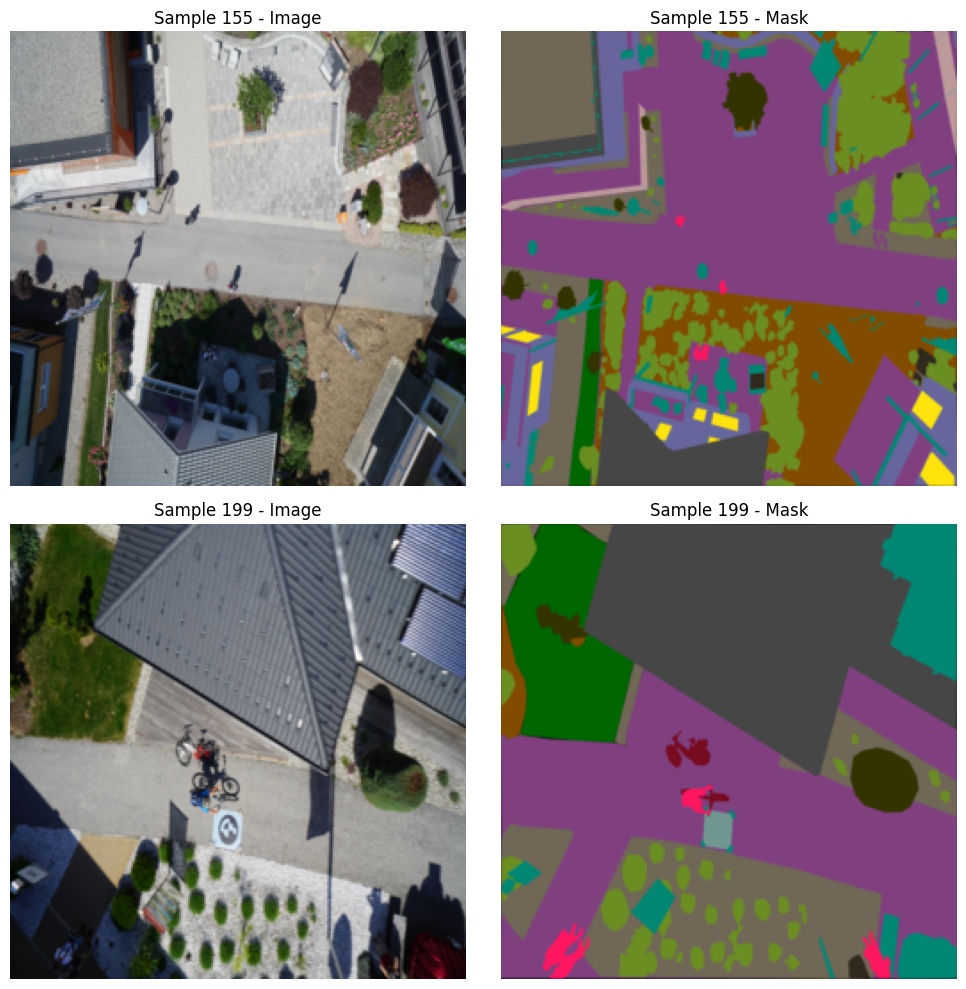

In [14]:
plot_samples(dataset, n=2)

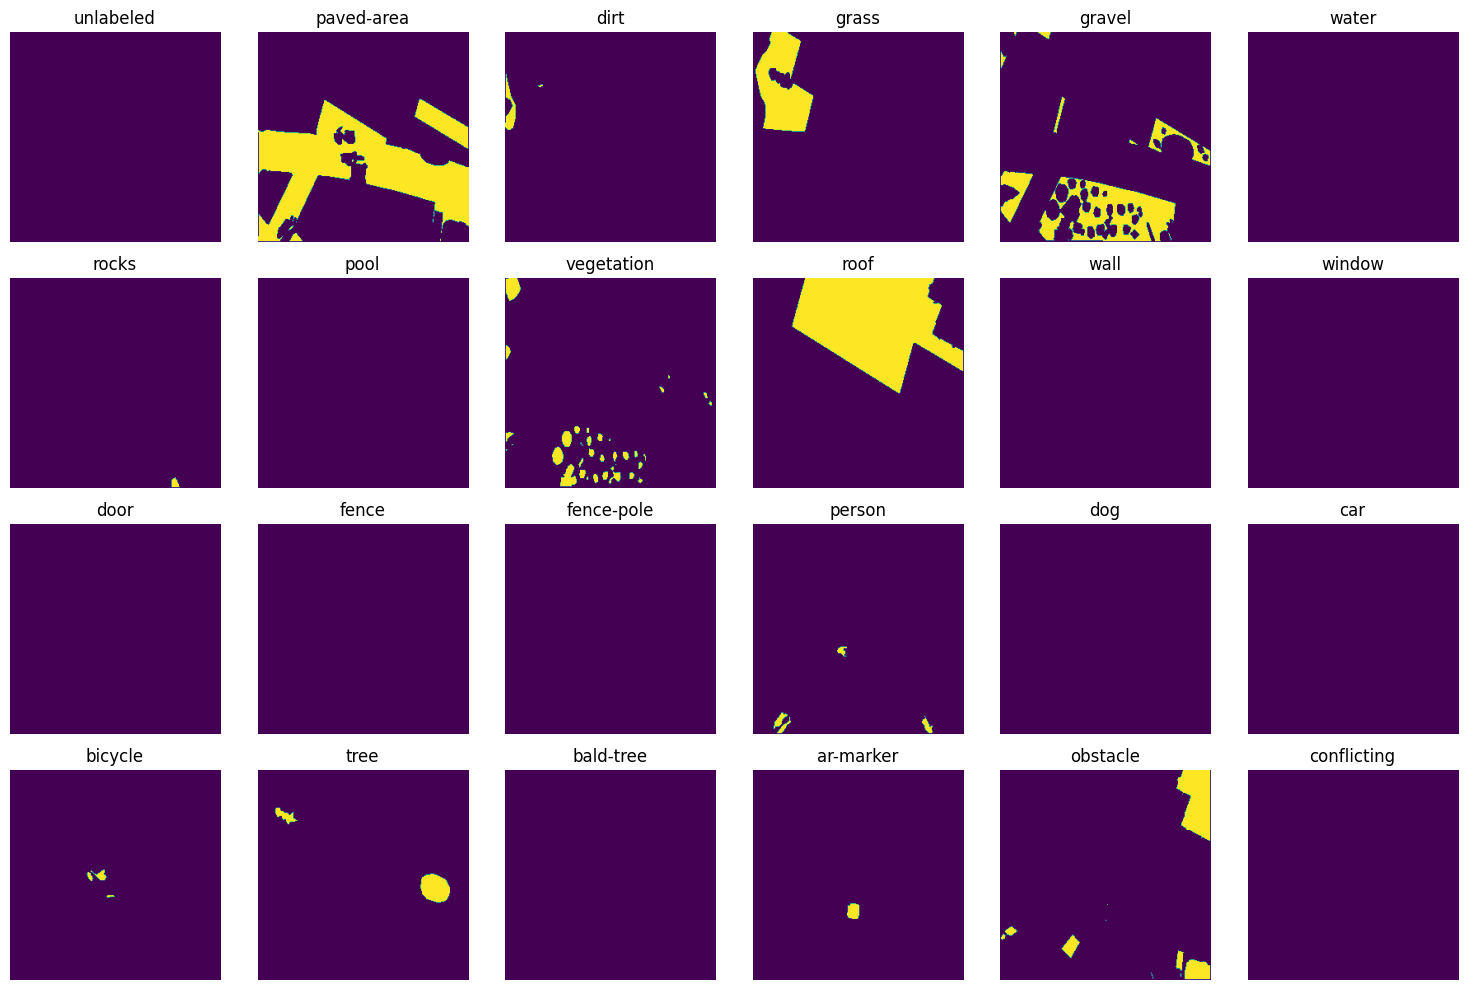

In [15]:
plot_multiclass(dataset[199][2], list(dataset.class_rgb.keys()))

In [7]:
loaders = create_loaders(dataset, proportions=[.80,.15,.05], batch_size=4)

train: 320
valid: 60
test: 20


In [8]:
fcn = FCN(3, 128, num_classes=num_classes)
print_parameters_count(fcn)

FCN parameters count: 1,491,224


In [9]:
fcn_trainer = Trainer(fcn, loaders['train'], loaders['val'])

In [75]:
fcn_trainer.start(101)

Epoch: 1/101..  Train Loss: 2.051 Valid Loss: 1.615 Train Accuracy: 0.290 Valid Accuracy: 0.446
Epoch: 11/101..  Train Loss: 0.944 Valid Loss: 0.830 Train Accuracy: 0.596 Valid Accuracy: 0.599
Epoch: 21/101..  Train Loss: 0.825 Valid Loss: 0.787 Train Accuracy: 0.639 Valid Accuracy: 0.611
Epoch: 31/101..  Train Loss: 0.746 Valid Loss: 0.675 Train Accuracy: 0.656 Valid Accuracy: 0.641
Epoch: 41/101..  Train Loss: 0.616 Valid Loss: 0.588 Train Accuracy: 0.677 Valid Accuracy: 0.650
Epoch: 51/101..  Train Loss: 0.598 Valid Loss: 0.630 Train Accuracy: 0.685 Valid Accuracy: 0.629
Epoch: 61/101..  Train Loss: 0.532 Valid Loss: 0.563 Train Accuracy: 0.696 Valid Accuracy: 0.651
Epoch: 71/101..  Train Loss: 0.546 Valid Loss: 0.652 Train Accuracy: 0.702 Valid Accuracy: 0.634
Epoch: 81/101..  Train Loss: 0.474 Valid Loss: 0.491 Train Accuracy: 0.705 Valid Accuracy: 0.667
Epoch: 91/101..  Train Loss: 0.432 Valid Loss: 0.484 Train Accuracy: 0.713 Valid Accuracy: 0.673
Epoch: 101/101..  Train Loss: 0

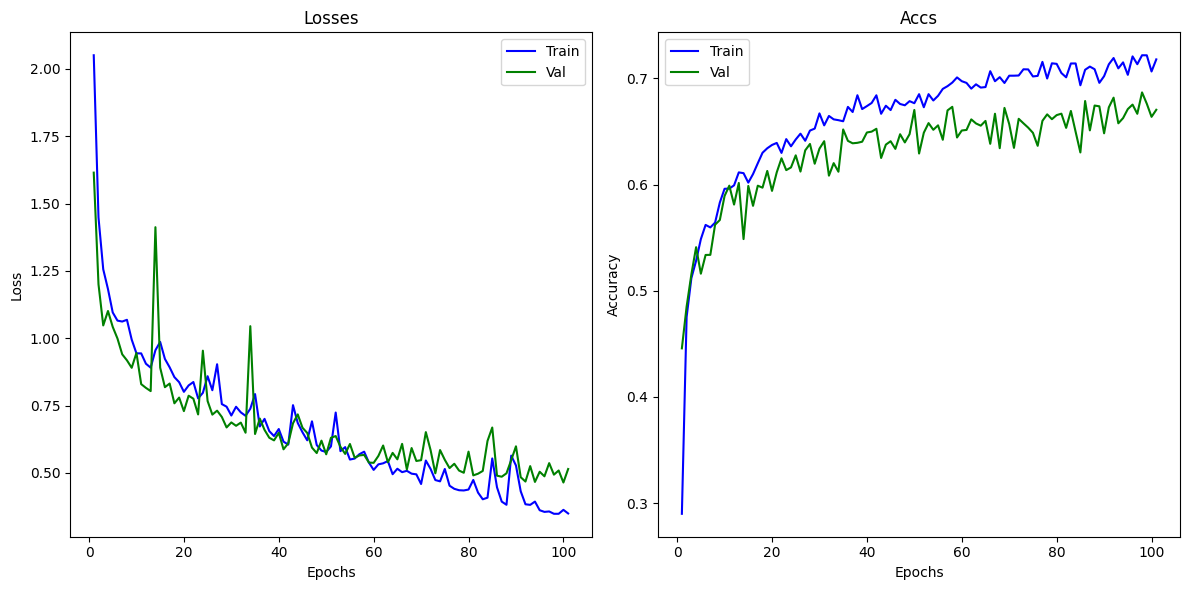

In [87]:
fcn_trainer.plot_history()

In [88]:
fcn_trainer.best_acc

0.6867372702186764

In [93]:
fcn_trainer.load_checkpoint()
fcn_trainer.validate(loaders['test'])

(0.5346199095249176, 0.6676208134948578)

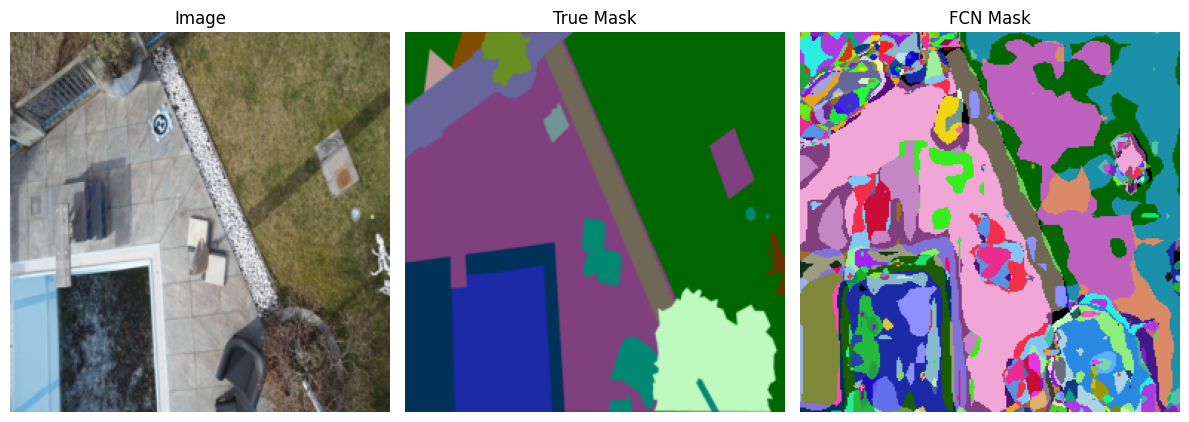

In [96]:
single_test(fcn, loaders['test'], class_rgb)

In [11]:
unet = UNet(3, 32, num_classes, bilinear=True)
print_parameters_count(unet)

UNet parameters count: 4,319,160


In [12]:
unet_trainer = Trainer(unet, loaders['train'], loaders['val'])

In [72]:
unet_trainer.start(101)

Epoch: 1/101..  Train Loss: 2.449 Valid Loss: 1.974 Train Accuracy: 0.467 Valid Accuracy: 0.510
Epoch: 11/101..  Train Loss: 0.977 Valid Loss: 0.941 Train Accuracy: 0.647 Valid Accuracy: 0.595
Epoch: 21/101..  Train Loss: 0.832 Valid Loss: 0.812 Train Accuracy: 0.657 Valid Accuracy: 0.624
Epoch: 31/101..  Train Loss: 0.680 Valid Loss: 0.661 Train Accuracy: 0.693 Valid Accuracy: 0.648
Epoch: 41/101..  Train Loss: 0.574 Valid Loss: 0.732 Train Accuracy: 0.710 Valid Accuracy: 0.666
Epoch: 51/101..  Train Loss: 0.498 Valid Loss: 0.494 Train Accuracy: 0.712 Valid Accuracy: 0.697
Epoch: 61/101..  Train Loss: 0.440 Valid Loss: 0.483 Train Accuracy: 0.724 Valid Accuracy: 0.676
Epoch: 71/101..  Train Loss: 0.505 Valid Loss: 0.527 Train Accuracy: 0.714 Valid Accuracy: 0.667
Epoch: 81/101..  Train Loss: 0.320 Valid Loss: 0.386 Train Accuracy: 0.726 Valid Accuracy: 0.673
Epoch: 91/101..  Train Loss: 0.420 Valid Loss: 1.507 Train Accuracy: 0.727 Valid Accuracy: 0.580
Epoch: 101/101..  Train Loss: 0

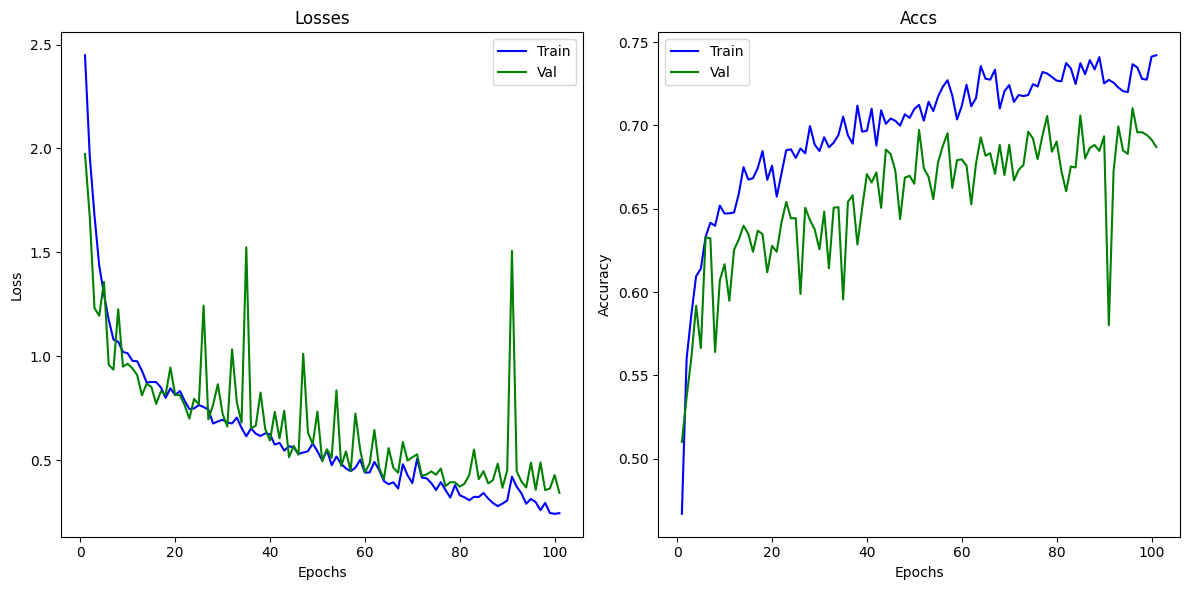

In [76]:
unet_trainer.plot_history()

In [77]:
unet_trainer.best_acc

0.7103265905042633

In [79]:
unet_trainer.load_checkpoint()
unet_trainer.validate(loaders['test'])

(0.3113811880350113, 0.7037728933133695)

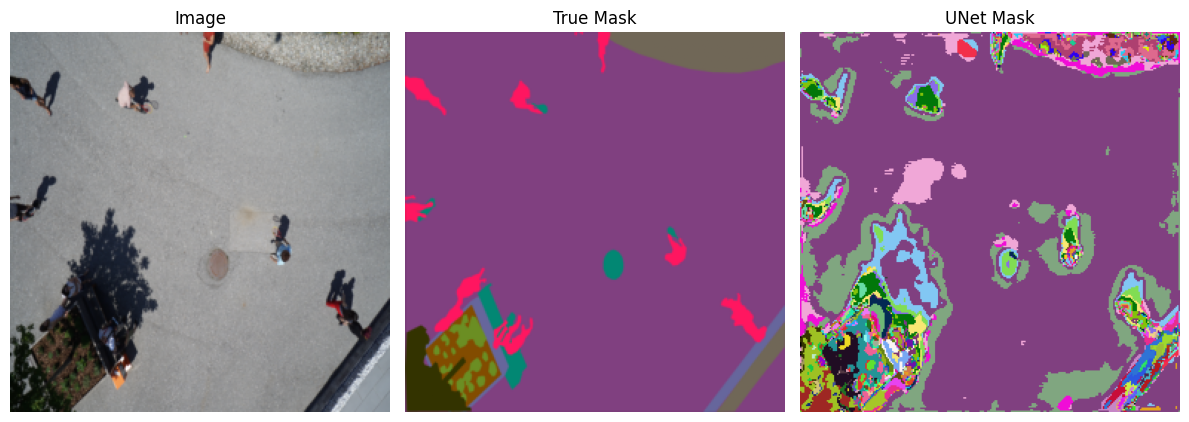

In [86]:
single_test(unet, loaders['test'], class_rgb)

In [15]:
deeplab = DeepLab(output_stride=16, num_classes=num_classes)
print_parameters_count(deeplab)

DeepLab parameters count: 59,345,080


In [16]:
deeplab_trainer = Trainer(deeplab, loaders['train'], loaders['val'])

In [101]:
deeplab_trainer.log_period = 3
deeplab_trainer.start(31)

Epoch: 1/31..  Train Loss: 2.127 Valid Loss: 1.424 Train Accuracy: 0.419 Valid Accuracy: 0.490
Epoch: 4/31..  Train Loss: 1.140 Valid Loss: 0.910 Train Accuracy: 0.594 Valid Accuracy: 0.613
Epoch: 7/31..  Train Loss: 0.962 Valid Loss: 0.878 Train Accuracy: 0.632 Valid Accuracy: 0.576
Epoch: 10/31..  Train Loss: 0.875 Valid Loss: 0.993 Train Accuracy: 0.648 Valid Accuracy: 0.602
Epoch: 13/31..  Train Loss: 0.798 Valid Loss: 0.833 Train Accuracy: 0.672 Valid Accuracy: 0.612
Epoch: 16/31..  Train Loss: 0.758 Valid Loss: 0.767 Train Accuracy: 0.677 Valid Accuracy: 0.637
Epoch: 19/31..  Train Loss: 0.669 Valid Loss: 0.713 Train Accuracy: 0.688 Valid Accuracy: 0.646
Epoch: 22/31..  Train Loss: 0.654 Valid Loss: 0.677 Train Accuracy: 0.687 Valid Accuracy: 0.629
Epoch: 25/31..  Train Loss: 0.595 Valid Loss: 0.817 Train Accuracy: 0.691 Valid Accuracy: 0.616
Epoch: 28/31..  Train Loss: 0.546 Valid Loss: 0.711 Train Accuracy: 0.704 Valid Accuracy: 0.665
Epoch: 31/31..  Train Loss: 0.555 Valid Los

In [102]:
deeplab_trainer.log_period = 10
deeplab_trainer.start(71, clear=False)

Epoch: 1/71..  Train Loss: 0.537 Valid Loss: 0.814 Train Accuracy: 0.703 Valid Accuracy: 0.624
Epoch: 11/71..  Train Loss: 0.356 Valid Loss: 0.732 Train Accuracy: 0.723 Valid Accuracy: 0.665
Epoch: 21/71..  Train Loss: 0.241 Valid Loss: 1.880 Train Accuracy: 0.728 Valid Accuracy: 0.615
Epoch: 31/71..  Train Loss: 0.349 Valid Loss: 1.103 Train Accuracy: 0.720 Valid Accuracy: 0.625
Epoch: 41/71..  Train Loss: 0.136 Valid Loss: 0.528 Train Accuracy: 0.754 Valid Accuracy: 0.672
Epoch: 51/71..  Train Loss: 0.244 Valid Loss: 1.051 Train Accuracy: 0.739 Valid Accuracy: 0.648
Epoch: 61/71..  Train Loss: 0.088 Valid Loss: 0.613 Train Accuracy: 0.755 Valid Accuracy: 0.660
Epoch: 71/71..  Train Loss: 0.129 Valid Loss: 0.599 Train Accuracy: 0.753 Valid Accuracy: 0.674


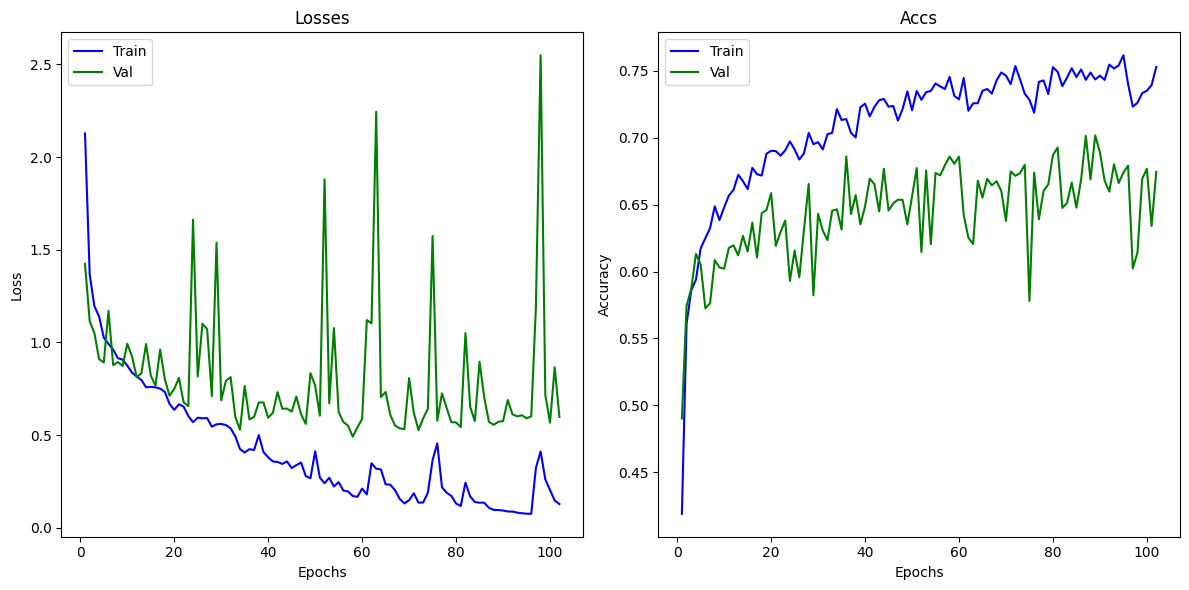

In [104]:
deeplab_trainer.plot_history()

In [105]:
deeplab_trainer.best_acc

0.7017286332967339

In [107]:
deeplab_trainer.load_checkpoint()
deeplab_trainer.validate(loaders['test'])

(0.46906672716140746, 0.687631103643982)

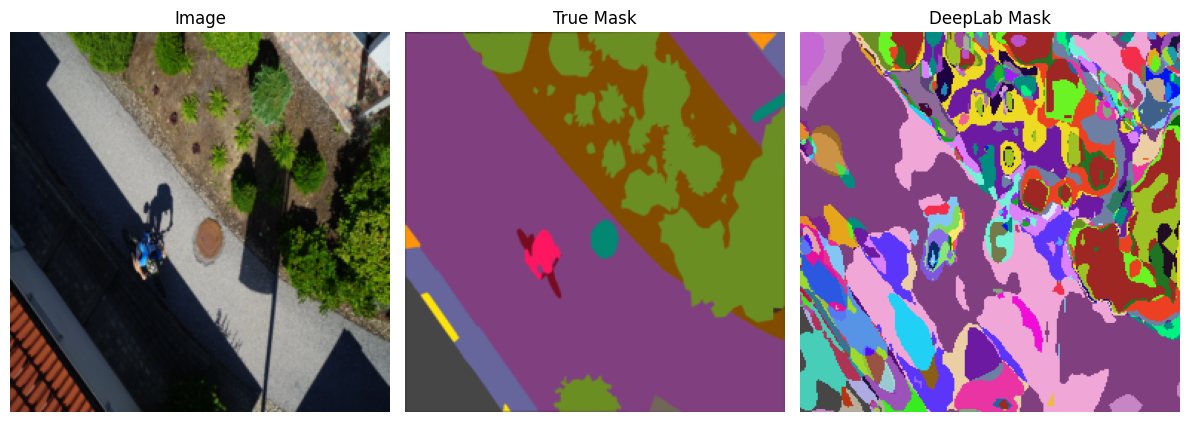

In [108]:
single_test(deeplab, loaders['test'], class_rgb)

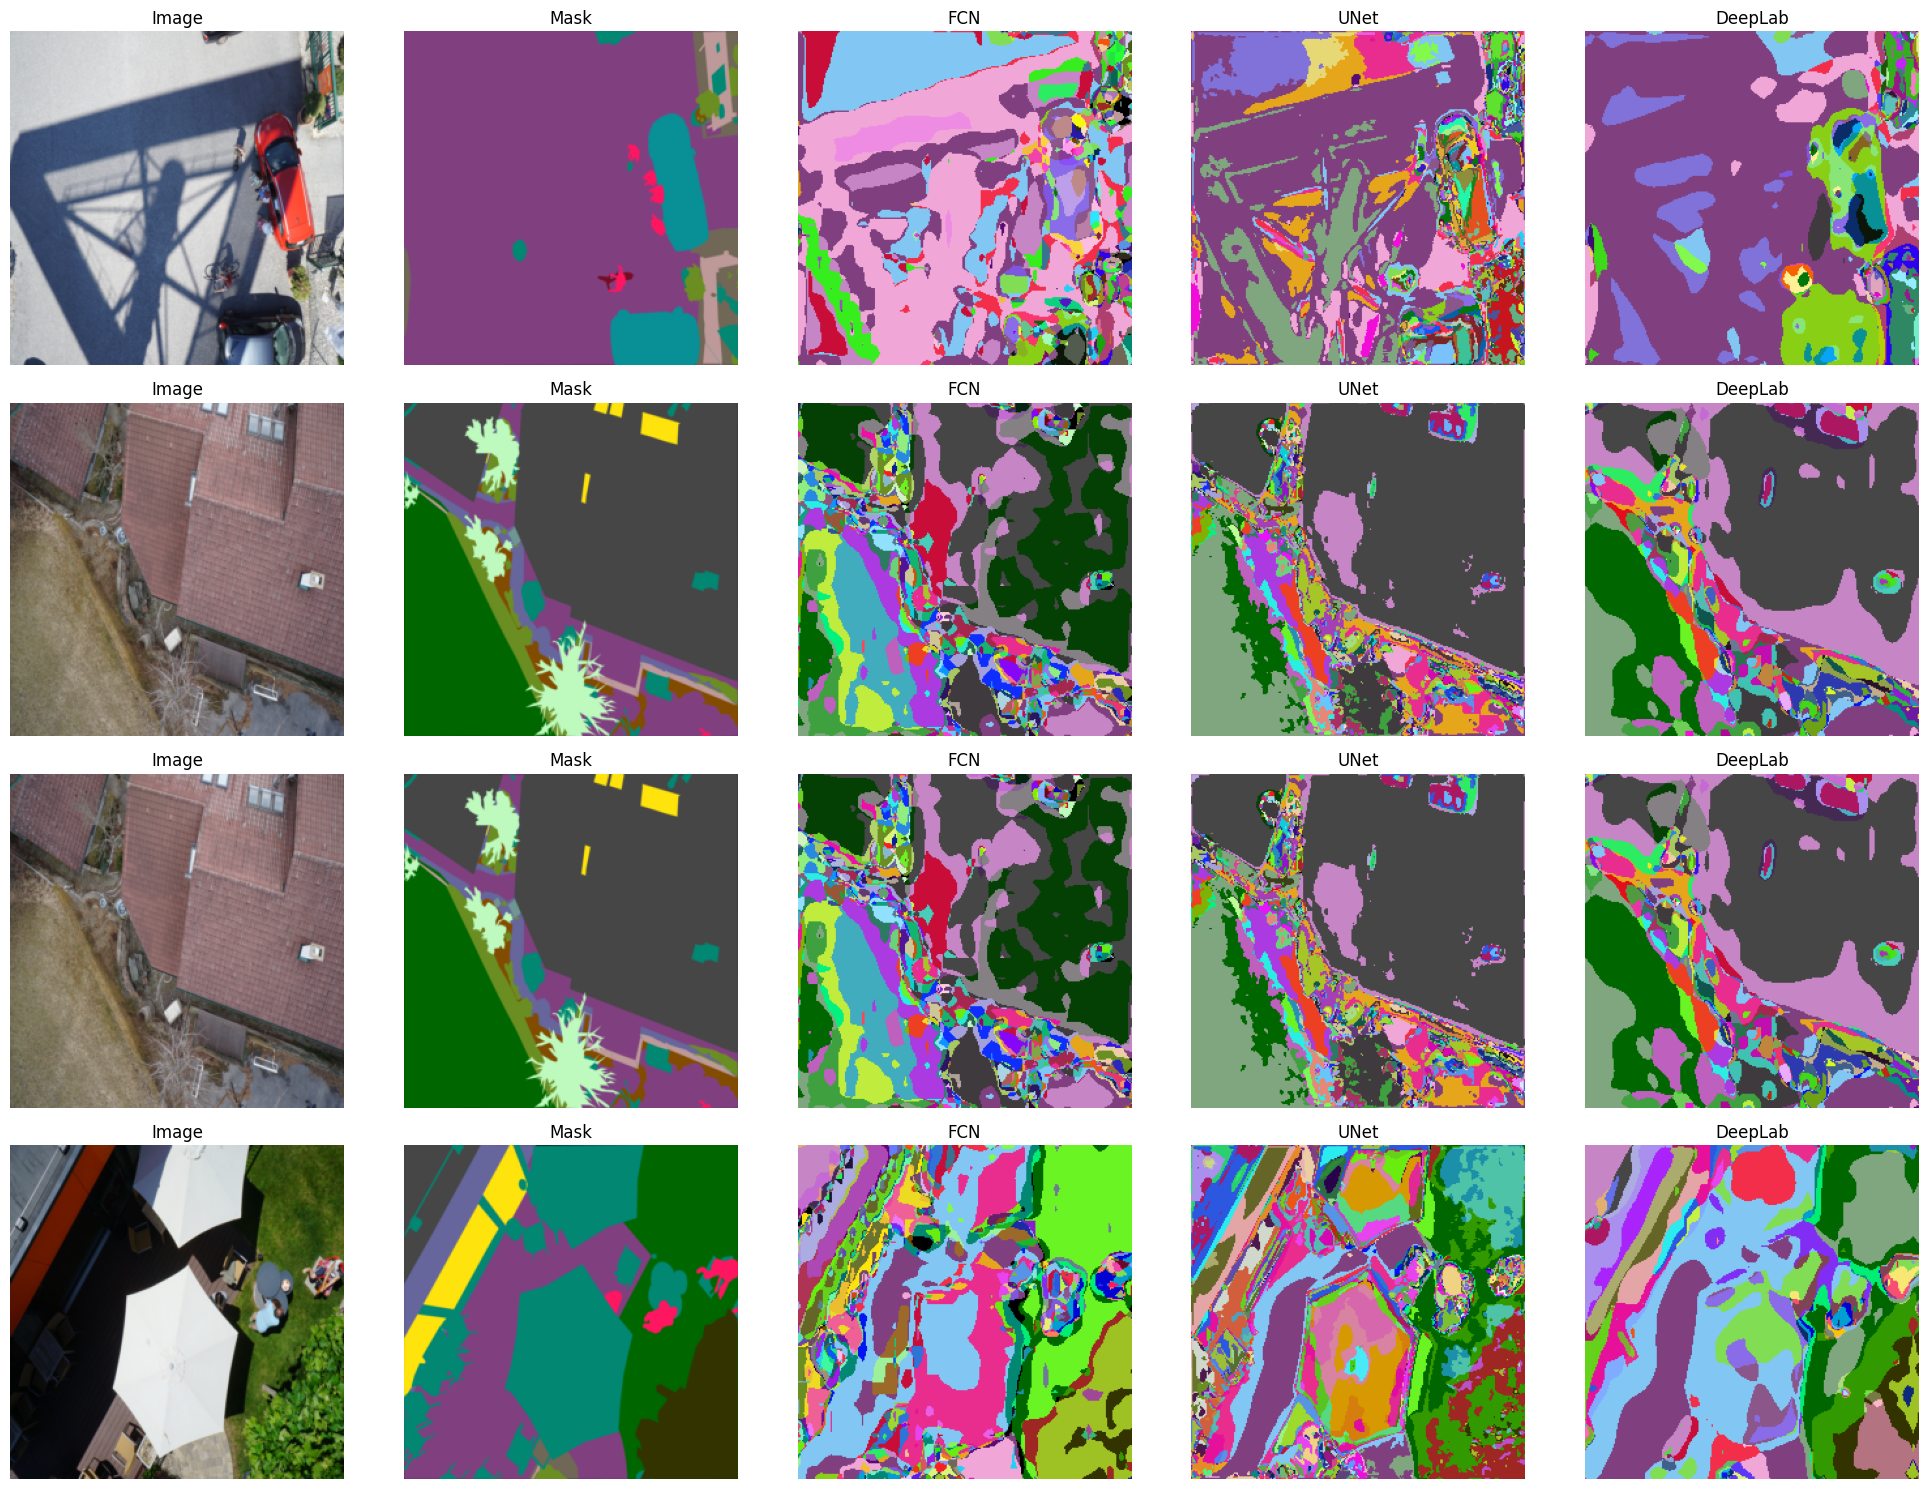

In [18]:
triple_test(loaders['test'], class_rgb, fcn, unet, deeplab)